# Combine sectorial spatial inventories
This notebook loads sectorial invenotry files from the data folder and combines them into a single datafile.

In [1]:
#!/usr/bin/env python3
import os

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# Notebook Functions

In [2]:
# fetch file from geopackage
def fetch_gpkg(path:str, epsg:str = '25832') -> gpd.GeoDataFrame:
    """Reads data from geopackage and converts it to specified coordinate reference system.

    Args:
        path (str): path to data
        epsg (str, optional): coordinate reference system. Defaults to '25832'.

    Returns:
        pd.GeoDataFrame: data from file
    """
    df = gpd.read_file(path).to_crs(epsg)
    return df

In [3]:
# combine inventory from different gpkg files
def combine_inventory(base_inventory, append_inventory,
                      year, sector, sourcetype, unit_factors,
                      append_geometry = False) -> gpd.GeoDataFrame:
    """Combines base inventory with additional inventory.

    Args:
        base_inventory (GeoDataframe): base inventory (TNO downscaled)
        append_inventory (GeoDataframe): Additional secotor to be added
        year (string): year of the inventory to be combined
        sector (string): GNFR Sector (e.g. F = road transport)
        sourcetype (string): "A" for area sources, "P" for point sources
        unit_factors (dict): dictionary with conversion factors for each component
        append_geometry (Bool): False if no geometry check should be performed. 
        This can be used to append additional geometry or point sources to the inventory.

    Returns:
        GeoDataframe: Combined inventory
    """
    gdf1 = base_inventory
    gdf2 = append_inventory

    for component, factor in unit_factors.items():
        gdf2[component] = gdf2[component]*factor

    if append_geometry:
        gdf2_comb = gdf2
    else: 
        gdf2['geometry'] = gdf2.centroid
        gdf2_comb = gpd.sjoin(gdf1[['id','geometry']].drop_duplicates('geometry'), gdf2, 
                             how = 'inner').drop('index_right', axis=1).dropna()

    gdf2_comb['Year']=year
    gdf2_comb['GNFR_Sector']=sector
    gdf2_comb['SourceType']=sourcetype
    gdf2_comb['ISO3']='DEU'

    combined = pd.concat([gdf1,gdf2_comb], ignore_index=True)
    combined = combined.sort_values('id').reset_index(drop=True)
    
    return gpd.GeoDataFrame(combined, geometry = 'geometry') # return as geodataframe

In [4]:
# plot inventory from different sources or the city total of defined component
def plot_inventory(df:gpd.GeoDataFrame,
                   component:'str',
                   sector:'str'='sum') -> None:

     fig, ax = plt.subplots(figsize=(10,10))
     
     if sector == 'sum': 
          plot_sum = df.groupby('id').agg({'CO2':lambda x: x.sum()* 1e-3,
                                        'CO2_bio':lambda x: x.sum()* 1e-3, 
                                        'NOX':'sum',
                                        'CO':'sum',
                                        'CH4':'sum', 
                                        'geometry': lambda x: x.iloc[0]})

          gpd.GeoDataFrame(plot_sum, geometry= 'geometry').plot(ax = ax, 
                                                                column = component, 
                                                                cmap = matplotlib.colormaps['PuBu'], 
                                                                scheme = "JenksCaspall",
                                                                vmin = 0,
                                                                k = 7,  
                                                                legend = True)
          
          # plot point sources
          max_value = df[df['GNFR_Sector']=='A'][component].max()
          df['point_size'] = 500*(df['CO2']/max_value)
          df[df['GNFR_Sector']=='A'].plot(ax = ax,
                                          markersize = 100* np.log1p(df[df['GNFR_Sector']=='A']['point_size']), 
                                          color = 'black')


          ax.set_title(f'Munich {component} Emissions {df['Year'].iloc[0]}')
          ax.get_legend().set_title("CO2 [kg/cell/year]")
          ax.set_xlabel('Latitude')
          ax.set_ylabel('Longitude')
          
     else: 
          df[df['GNFR_Sector']==sector].plot(ax = ax, 
                                             column = component, 
                                             cmap = matplotlib.colormaps['PuBu'])
     
     return None

In [5]:
# calculate sum of emissions by GNFR sector to be saved as xlsx file
def calculate_sum(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate the sum of emissions by GNFR sector.

    Args:
        df (pd.DataFrame): Input DataFrame with emissions data.

    Returns:
        pd.DataFrame: DataFrame with summed emissions by GNFR sector.
    """
    
    df = df.groupby('GNFR_Sector').agg({'CO2':'sum',
                                        'CO2_bio':'sum',
                                        'NOX':'sum',
                                        'CO':'sum',
                                        'CH4':'sum', 
                                        'PM': 'sum'})
    df['CO2']= df['CO2']*1e-6 # convert to kt
    df['CO2_bio']= df['CO2_bio']*1e-6 # convert to kt
    df['NOX']= df['NOX']*1e-3 # convert to t
    df['CH4']= df['CH4']*1e-3 # convert to t
    df['CO']= df['CO']*1e-3 # convert to t
    df['PM']= df['PM']*1e-3 # convert to t
    
    # Calculate the sum of each column
    totals = df.sum()

    # Convert the totals to a DataFrame and transpose it
    totals_df = totals.to_frame().T

    # Set the index name for the totals row
    totals_df.index = ['Total']

    # Append the totals row to the DataFrame using pd.concat
    df = pd.concat([df, totals_df])

    return df

### Collect filepaths for all sectorial inventories by year

In [36]:
YEAR = '2024'

# assemble filepaths
root = os.path.dirname(os.path.abspath(''))
gnfr_a_path = os.path.join(root, 'data', 'GNFR A', YEAR, f'{YEAR}_GNFR_A.gpkg')
gnfr_f_hot_path = os.path.join(root, 'data', 'GNFR F', YEAR, f'{YEAR}_GNFR_F_100m_hot.gpkg')
gnfr_f_csee_path = os.path.join(root, 'data', 'GNFR F', YEAR, f'{YEAR}_GNFR_F_100m_cold.gpkg')
gnfr_c_path = os.path.join(root, 'data', 'GNFR C', YEAR, f'{YEAR}_GNFR_C.gpkg')

# only available for 2022
respiration_path = os.path.join(root, 'data', 'Human Respiration', '2022_human_respiration.gpkg')

# only available from 2019 until 2022
if YEAR in ['2023','2024']:
    other_sectors_path = os.path.join(root, 'data', 'Other Sectors', 'TNO_GHGco_v4_1_highres_year2022_Munich.gpkg') 
else: 
    other_sectors_path = os.path.join(root, 'data', 'Other Sectors', f'TNO_GHGco_v4_1_highres_year{YEAR}_Munich.gpkg')

# check file availability
assert os.path.exists(other_sectors_path), 'Other sectors path does not exist'
assert os.path.exists(gnfr_a_path), 'GNFR A path does not exist'
assert os.path.exists(gnfr_f_hot_path), 'GNFR F hot path does not exist'
assert os.path.exists(gnfr_f_csee_path), 'GNFR F cold path does not exist'
assert os.path.exists(gnfr_c_path), 'GNFR C path does not exist'
assert os.path.exists(respiration_path), 'Respiration path does not exist'

### Load and preprocess sectorial inventories

In [37]:
# fetch data from geopackages
other_sectors = fetch_gpkg(other_sectors_path)
gnfr_a = fetch_gpkg(gnfr_a_path)
gnfr_f_hot = fetch_gpkg(gnfr_f_hot_path)
gnfr_f_csee = fetch_gpkg(gnfr_f_csee_path)
gnfr_c = fetch_gpkg(gnfr_c_path)
human_respirantion = fetch_gpkg(respiration_path)

# calculate biogenic CO2 emissions for road transport
gnfr_f_hot['CO2_bio'] = gnfr_f_hot['CO2(total)'] - gnfr_f_hot['CO2(rep)']
gnfr_f_csee['CO2_bio'] = gnfr_f_csee['CO2(total)'] - gnfr_f_csee['CO2(rep)']

# disaggregate HR emission in three different sectors
hr_outdoor = human_respirantion[['CO2_outdoor', 'geometry']].copy()
hr_outdoor = hr_outdoor.rename(columns = {'CO2_outdoor': 'CO2_bio'})
hr_residential = human_respirantion[['CO2_residential', 'geometry']].copy()
hr_residential = hr_residential.rename(columns = {'CO2_residential': 'CO2_bio'})
hr_nonresidential = human_respirantion[['CO2_nonresidential', 'geometry']].copy()
hr_nonresidential = hr_nonresidential.rename(columns = {'CO2_nonresidential': 'CO2_bio'})

# rename columns
gnfr_f_hot = gnfr_f_hot.rename(columns = {'CO2(total)' : 'CO2', 'NOx' : 'NOX'})
gnfr_f_csee = gnfr_f_csee.rename(columns = {'CO2(total)' : 'CO2', 'NOx' : 'NOX'})
gnfr_c = gnfr_c.rename(columns = {'NOx' : 'NOX', 'PM10': 'PM'})
gnfr_a = gnfr_a.rename(columns = {'NOx' : 'NOX'})

# drop bottom up sectors from TNO inventory
BU_sectors = ['A','B','C','F']
other_sectors = other_sectors.drop(other_sectors[other_sectors['GNFR_Sector'].isin(BU_sectors)].index,
                                   axis = 0)

### Combine sectorial inventories

In [38]:
# use factors to convert components to kg/ year if not already in that unit
# GNFR A 
gnfr_a_factors = {'CO2':1, 'NOX': 1, 'CO': 1}
combined = combine_inventory(other_sectors, gnfr_a, 
                            YEAR, "A", "P", gnfr_a_factors, 
                            append_geometry = True)

# GNFR F
gnfr_f_factors = {'CO2':1, 'NOX': 1, 'CO': 1,
                  'PM': 1, 'NO2': 1, 'CH4': 1,
                  'CO2_bio' : 1}
combined = combine_inventory(combined, gnfr_f_hot, 
                            YEAR, "F_hot", "A", gnfr_f_factors)

combined = combine_inventory(combined, gnfr_f_csee, 
                            YEAR, "F_csee", "A", gnfr_f_factors)

# GNFR C
gnfr_c_factors = {'CO2':1, 'NOX': 1, 'CO': 1, 'PM': 1}
combined = combine_inventory(combined, gnfr_c, 
                            YEAR, "C", "A", gnfr_c_factors)

# HUMAN RESPIRATION
hr_factors = {'CO2_bio':1}
combined = combine_inventory(combined, hr_outdoor,
                            YEAR, "HR_outdoor", "A", hr_factors)
combined = combine_inventory(combined, hr_residential,
                            YEAR, "HR_residential", "A", hr_factors)
combined = combine_inventory(combined, hr_nonresidential,
                            YEAR, "HR_nonresidential", "A", hr_factors)

combined['Year'] = YEAR

### Save spatial inventory and emission totals

In [39]:
SAVE_INVENTORY = True

columns_to_keep = ['id', 'ISO3', 'Year', 'GNFR_Sector', 'SourceType',
                   'CO2', 'NOX', 'CO', 'CH4', 'PM', 'CO2_bio',
                   'geometry']
inventory = combined[columns_to_keep].copy()

# calculate sector totals 
sector_totals = calculate_sum(inventory)
rename_sector_totals = {'CO2': 'CO2 [kt]', 'CO2_bio' : 'CO2_bio [kt]'}
for c in ['NOX', 'CO', 'CH4', 'PM']:
    rename_sector_totals.update({c : f'{c} [t]'})
sector_totals.rename(columns = rename_sector_totals, inplace=True)

if SAVE_INVENTORY: 
    save_inventory_path = os.path.join(root, 'output', YEAR, f'Munich_GHGco_v2_year{YEAR}.gpkg')
    save_totals_path = os.path.join(root, 'output', YEAR, f'sector_totals_{YEAR}.xlsx')
    inventory.to_file(save_inventory_path, driver = 'GPKG')
    sector_totals.to_excel(save_totals_path)

### Print sector totals and plot inventory

In [40]:
styled_df = (
    sector_totals.style
    .set_table_styles([{'selector': 'th',
                        'props': [('background-color', "#AE172939"),
                                  ('color', 'white'),
                                  ('font-weight', 'bold')]}])
    .set_properties(**{'text-align': 'right'})
    .format("{:.2f}")
)
styled_df

,CO2 [kt],CO2_bio [kt],NOX [t],CO [t],CH4 [t],PM [t]
A,2118.40,0.00,954.94,86.88,0.00,0.00
C,1622.71,0.00,616.93,356.62,0.00,4.14
D,41.32,0.00,0.00,0.00,250.61,0.00
E,34.51,0.00,3.65,227.87,14.40,0.00
F_csee,19.64,1.30,65.48,1133.42,8.72,0.81
F_hot,1074.39,73.06,1558.28,1833.86,41.50,23.13
G,0.00,0.00,0.00,0.00,0.00,0.00
HR_nonresidential,0.00,94.41,0.00,0.00,0.00,0.00
HR_outdoor,0.00,46.94,0.00,0.00,0.00,0.00
HR_residential,0.00,329.22,0.00,0.00,0.00,0.00


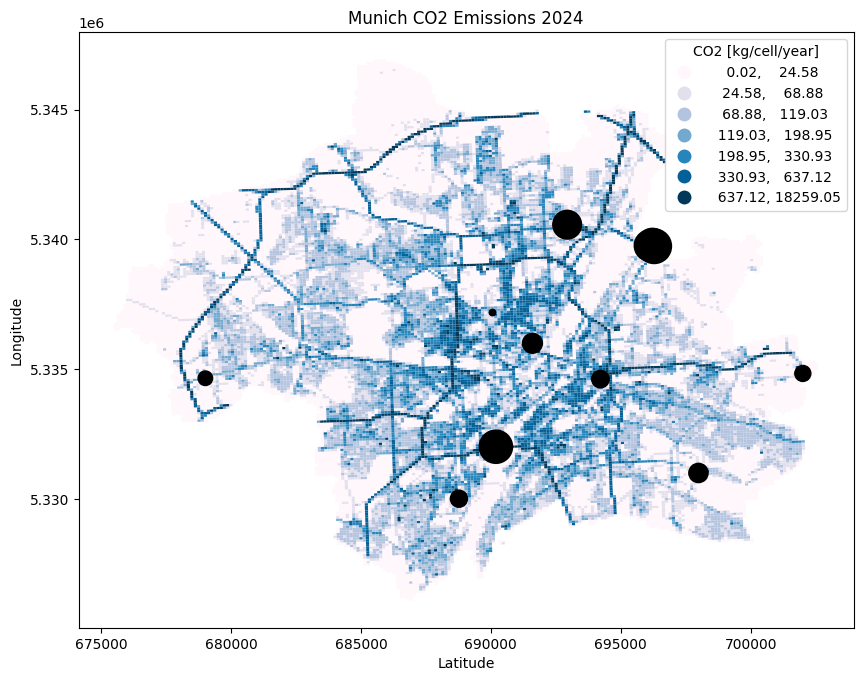

In [41]:
plot_inventory(inventory, 'CO2', 'sum')